In [235]:
# Cell 1: Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
import joblib

In [236]:
# Cell 2: Load and Preprocess Data
# Load the dataset
df = pd.read_csv('coconut_irrigation_data_with_water_level_8.csv')

# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Convert soil type to numerical
soil_type_mapping = {
    'Lateritic': 1,
    'Sandy Loam': 2,
    'Cinnamon Sand': 3,
    'Red Yellow Podzolic': 4,
    'Alluvial': 5
}

df['Soil Type'] = df['Soil Type'].map(soil_type_mapping)
joblib.dump(soil_type_mapping, 'soil_type_mapping.pkl')

['soil_type_mapping.pkl']

In [237]:
# Cell 3: Define Water Level Categories
def categorize_water_level(water_level):
    if 50 <= water_level <= 100:
        return 1  # High water need
    elif 30 <= water_level < 50:
        return 2  # Moderate water need
    elif 10 <= water_level < 30:
        return 3  # Low water need
    else:
        return 0  # No water needed

# Apply categorization
df['Water Level Category'] = df['Water Level (liters)'].apply(categorize_water_level)

In [238]:
# Cell 4: Prepare Features and Target
# Select features including Soil Type
X = df[[
    'Soil Type',
    'Soil Moisture (10 cm) (%)',
    'Soil Moisture (20 cm) (%)',
    'Soil Moisture (30 cm) (%)',
    'Plant Age (years)',
    'Temperature (°C)',
    'Humidity (%)',
    'Rain Status (0/1)'
]]
y = df['Water Level Category']

In [239]:
# Cell 5: Apply SMOTE and Split Data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42)

In [240]:
# Cell 6: Define Evaluation Functions
def get_water_level_range_string_from_category(category):
    if category == 1:
        return "50-100L\n(High)"
    elif category == 2:
        return "30-50L\n(Moderate)"
    elif category == 3:
        return "10-30L\n(Low)"
    elif category == 0:
        return "0L\n(None)"
    else:
        raise ValueError("Invalid category. Must be 0, 1, 2, or 3.")

def evaluate_model(model):
    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Model: {model.__class__.__name__}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    if isinstance(model, RandomForestClassifier):
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        #print("\nFeature Importance:")
        #print(feature_importance)
    
    # Visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_correct = conf_matrix.diagonal()
    class_total = conf_matrix.sum(axis=1)
    class_accuracy = class_correct / class_total * 100
    
    water_level_labels = [get_water_level_range_string_from_category(i) for i in range(4)]
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']
    
    # Bar plot
    bars = ax1.bar(range(4), class_accuracy, color=colors)
    ax1.set_title(f'Prediction Accuracy by Water Need Level\n{model.__class__.__name__}', pad=20)
    ax1.set_xlabel('Water Need Category (Liters)')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xticks(range(4))
    ax1.set_xticklabels(water_level_labels, rotation=0)
    ax1.set_ylim([0, 100])
    
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')
    
    # Pie chart
    class_percentages = (class_total / class_total.sum()) * 100
    wedges, texts, autotexts = ax2.pie(class_percentages,
                                       labels=water_level_labels,
                                       colors=colors,
                                       autopct='%1.1f%%',
                                       startangle=90)
    
    plt.setp(autotexts, size=8, weight="bold")
    plt.setp(texts, size=8)
    ax2.set_title(f'Distribution of Water Need Categories\n{model.__class__.__name__}', pad=20)
    
    legend_labels = [
        '0L (No water needed)',
        '50-100L (High water need)',
        '30-50L (Moderate water need)',
        '10-30L (Low water need)'
    ]
    ax2.legend(wedges, legend_labels,
              title="Water Need Categories",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))
    
    plt.tight_layout()
    plt.show()
    
    # Save model and features
    model_filename = f"{model.__class__.__name__.lower()}water_model.pkl"
    joblib.dump(model, model_filename)
    joblib.dump(X.columns.tolist(), 'feature_columns.pkl')
    print(f"\nModel exported as: {model_filename}")
    print("======================================================================================================================================")

Model: RandomForestClassifier
Accuracy: 0.8788052843193567
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       440
           1       0.88      0.85      0.86       449
           2       0.78      0.81      0.80       431
           3       0.87      0.92      0.89       421

    accuracy                           0.88      1741
   macro avg       0.88      0.88      0.88      1741
weighted avg       0.88      0.88      0.88      1741



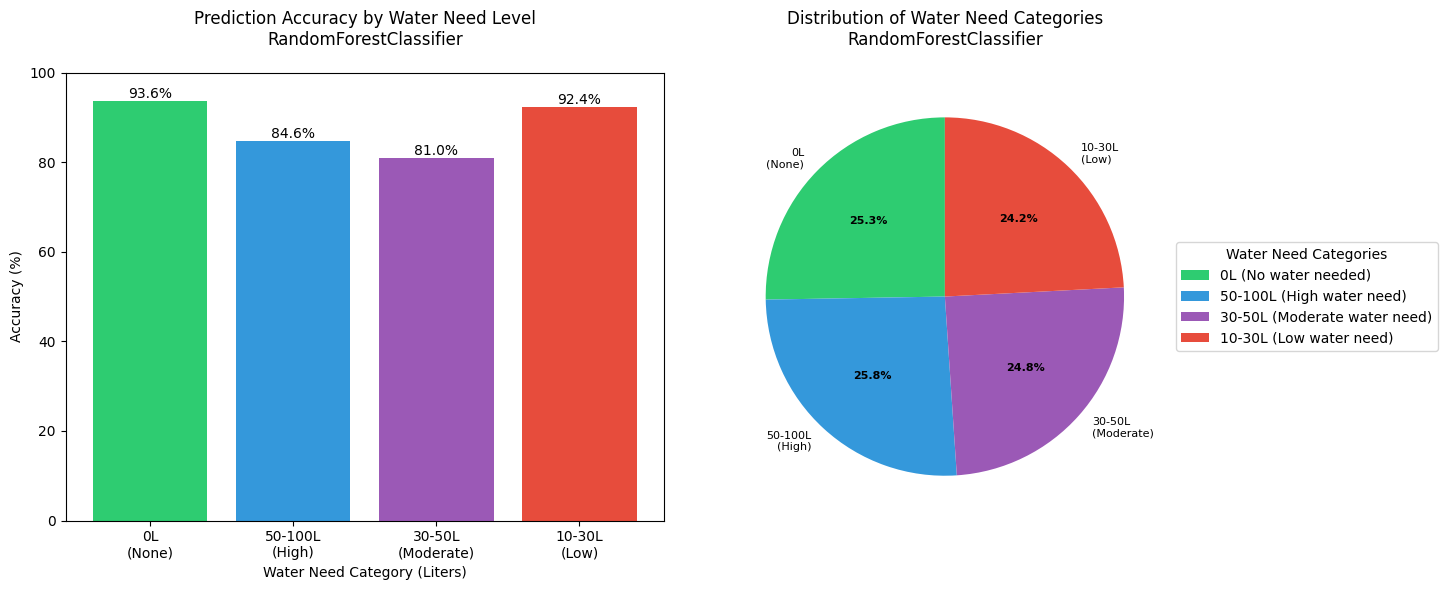


Model exported as: randomforestclassifierwater_model.pkl
Model: DecisionTreeClassifier
Accuracy: 0.8265364732912119
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       440
           1       0.83      0.77      0.80       449
           2       0.69      0.75      0.72       431
           3       0.86      0.83      0.84       421

    accuracy                           0.83      1741
   macro avg       0.83      0.83      0.83      1741
weighted avg       0.83      0.83      0.83      1741



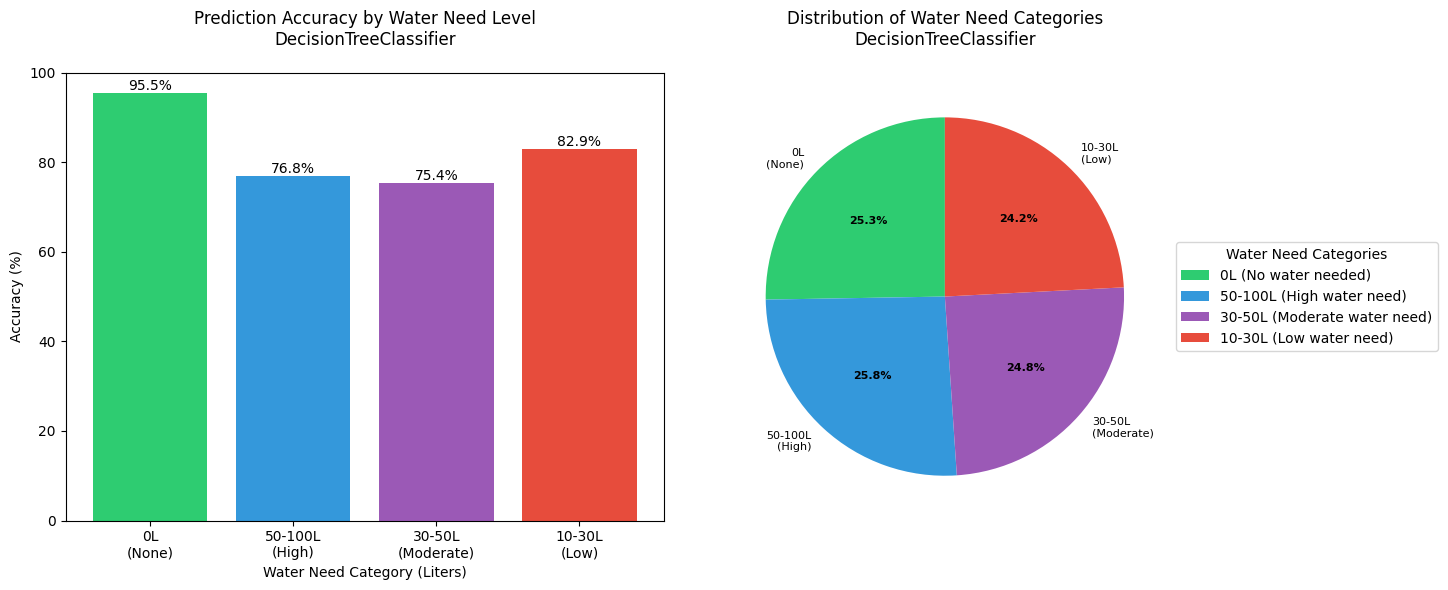


Model exported as: decisiontreeclassifierwater_model.pkl


c:\Users\sadee\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: LogisticRegression
Accuracy: 0.800689259046525
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       440
           1       0.82      0.79      0.81       449
           2       0.65      0.69      0.67       431
           3       0.77      0.82      0.79       421

    accuracy                           0.80      1741
   macro avg       0.81      0.80      0.80      1741
weighted avg       0.81      0.80      0.80      1741



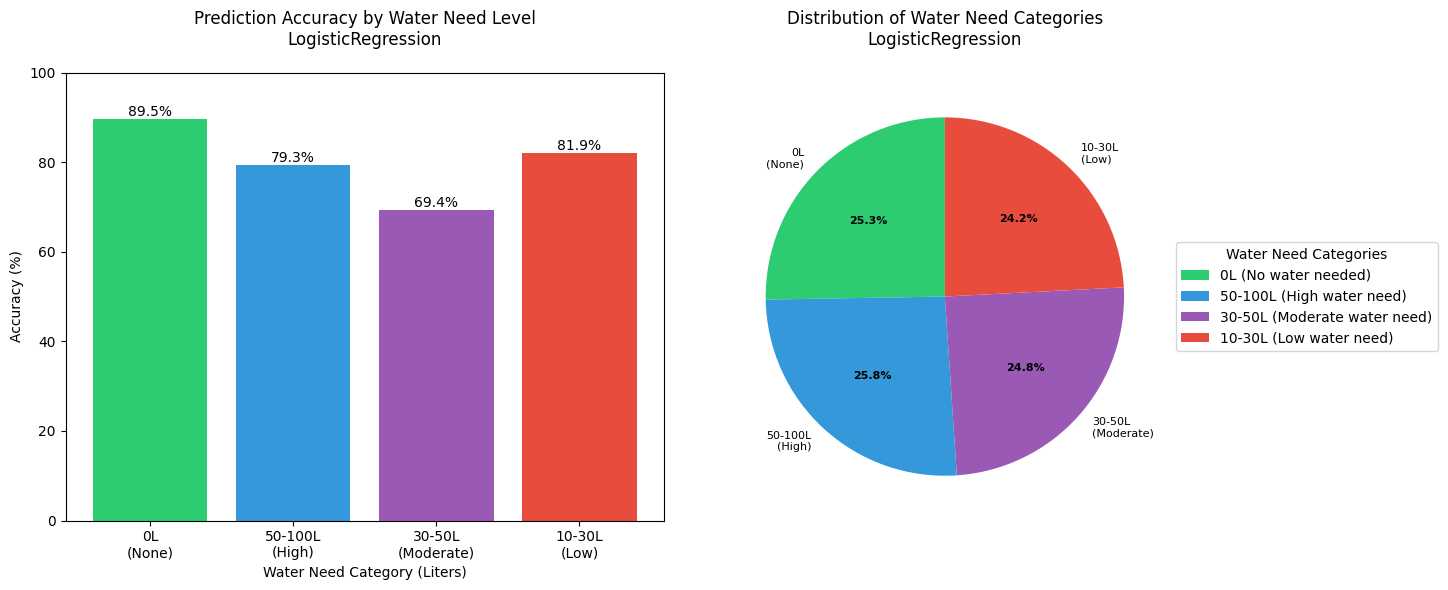


Model exported as: logisticregressionwater_model.pkl


In [241]:
# Cell 7: Train Models
models = [
    RandomForestClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    LogisticRegression(max_iter=1000, random_state=42)
]

for model in models:
    evaluate_model(model)

In [242]:
# Cell 8: Updated Model Selection with Scaling
from sklearn.preprocessing import StandardScaler

def find_best_model():
    """
    Test all models with proper scaling and return the one with highest accuracy
    """
    # Initialize scaler
    scaler = StandardScaler()
    
    # Scale the features
    X_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Save scaler for predictions
    joblib.dump(scaler, 'scaler.pkl')
    
    # Define models with optimized parameters
    models = {
        'RandomForest': RandomForestClassifier(
            random_state=42,
            n_estimators=100
        ),
        'DecisionTree': DecisionTreeClassifier(
            random_state=42,
            max_depth=10
        ),
        'LogisticRegression': LogisticRegression(
            random_state=42,
            max_iter=2000,  # Increased iterations
            solver='lbfgs',
            multi_class='multinomial',
            C=1.0,  # Regularization strength
            class_weight='balanced'
        )
    }
    
    best_accuracy = 0
    best_model = None
    best_model_name = None
    
    for name, model in models.items():
        # Train model on scaled data
        model.fit(X_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
            best_model_name = name
    
    print(f"\nBest Model: {best_model_name}")
    print(f"Accuracy: {best_accuracy:.4f}")
    
    # Save best model
    joblib.dump(best_model, 'best_model.pkl')
    return best_model, best_model_name

def predict_water_need(soil_type, moisture_10cm, moisture_20cm, moisture_30cm,
                      plant_age, temperature, humidity, rain_status):
    """
    Predict using the best performing model with scaled data
    """
    try:
        # Load the model, scaler, and mappings
        model = joblib.load('best_model.pkl')
        scaler = joblib.load('scaler.pkl')
        soil_mapping = joblib.load('soil_type_mapping.pkl')
        
        # Create input data
        new_data = pd.DataFrame({
            'Soil Type': [soil_mapping[soil_type]],
            'Soil Moisture (10 cm) (%)': [moisture_10cm],
            'Soil Moisture (20 cm) (%)': [moisture_20cm],
            'Soil Moisture (30 cm) (%)': [moisture_30cm],
            'Plant Age (years)': [plant_age],
            'Temperature (°C)': [temperature],
            'Humidity (%)': [humidity],
            'Rain Status (0/1)': [rain_status]
        })
        
        # Scale the input data
        new_data_scaled = scaler.transform(new_data)
        
        # Make prediction
        prediction = model.predict(new_data_scaled)[0]
        probabilities = model.predict_proba(new_data_scaled)[0]
        
        return prediction, probabilities
        
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None, None

In [243]:
df.head(2)

,Date,Soil Type,Soil Moisture (10 cm) (%),Soil Moisture (20 cm) (%),Soil Moisture (30 cm) (%),Plant Age (years),Temperature (°C),Humidity (%),Rainfall (mm),Rain Status (0/1),Irrigation Status (0/1),Water Level (liters),Water Level Category
0,2020-04-22,4,36.867627,21.865596,38.507507,10,25.307124,73.814358,2.578859,1,0,0.0,0
1,2023-12-03,1,59.917928,52.812786,56.767034,10,25.307124,73.814358,0.000000,0,0,0.0,0


c:\Users\sadee\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Best Model: RandomForest
Accuracy: 0.8782


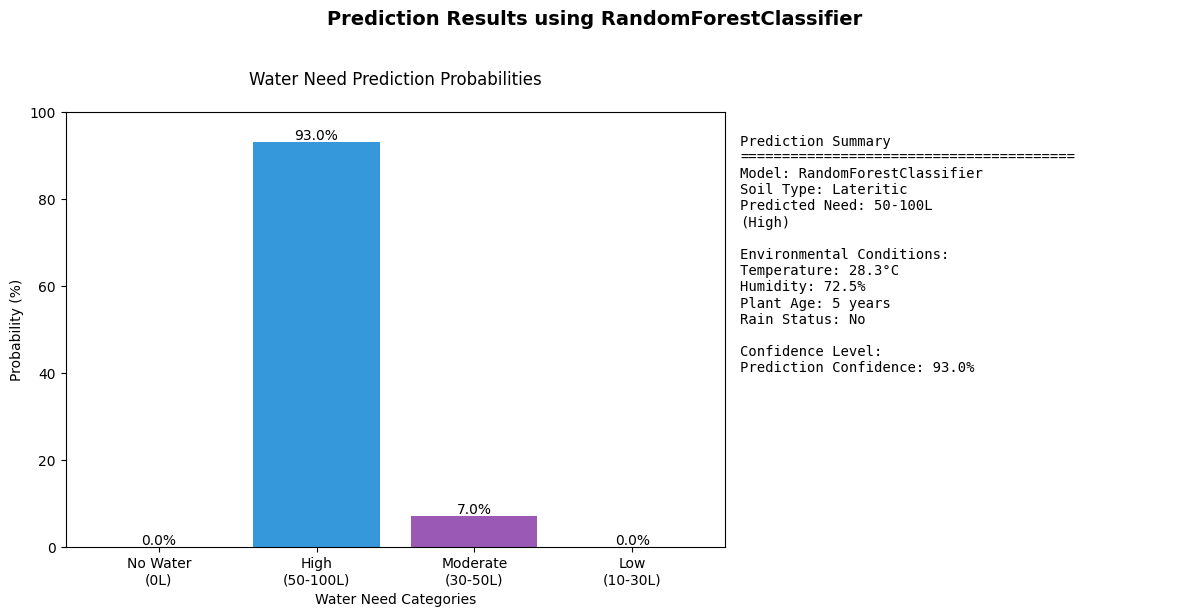


Detailed Prediction Results:
--------------------------------------------------
Model Used: RandomForestClassifier
Predicted Category: 1

Category Probabilities:
No Water: 0.0%
High (50-100L): 93.0%
Moderate (30-50L): 7.0%
Low (10-30L): 0.0%


In [244]:
# Cell 9: Example Usage with Fixed Model Name
def visualize_prediction(prediction, probabilities, input_data, model_name):
    """
    Visualize prediction results with bar graph and model name
    """
    # Get proper model name
    if isinstance(model_name, tuple):
        model_name = model_name[0].__class__.__name__  # Get actual model name from tuple
    
    # Create figure
    fig = plt.figure(figsize=(12, 6))
    fig.suptitle(f'Prediction Results using {model_name}', fontsize=14, fontweight='bold', y=1.02)
    
    # Rest of visualization code remains the same...
    gs = plt.GridSpec(1, 2, width_ratios=[1.5, 1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    categories = ['No Water\n(0L)', 'High\n(50-100L)', 'Moderate\n(30-50L)', 'Low\n(10-30L)']
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']
    
    bars = ax1.bar(categories, probabilities * 100, color=colors)
    ax1.set_title('Water Need Prediction Probabilities', pad=20)
    ax1.set_xlabel('Water Need Categories')
    ax1.set_ylabel('Probability (%)')
    ax1.set_ylim([0, 100])
    
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')

    ax2.axis('off')
    summary_text = [
        f"Prediction Summary",
        f"{'=' * 40}",
        f"Model: {model_name}",
        f"Soil Type: {input_data['soil_type']}",
        f"Predicted Need: {get_water_level_range_string_from_category(prediction)}",
        f"\nEnvironmental Conditions:",
        f"Temperature: {input_data['temperature']:.1f}°C",
        f"Humidity: {input_data['humidity']:.1f}%",
        f"Plant Age: {input_data['plant_age']} years",
        f"Rain Status: {'Yes' if input_data['rain_status'] else 'No'}",
        f"\nConfidence Level:",
        f"Prediction Confidence: {max(probabilities)*100:.1f}%"
    ]
    
    ax2.text(0, 0.95, '\n'.join(summary_text),
            fontsize=10, fontfamily='monospace',
            verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

# Test the model and get prediction
best_model = find_best_model()  # This will print the best model name

# Fix model name retrieval
if isinstance(best_model, tuple):
    model_name = best_model[0].__class__.__name__
    model_to_use = best_model[0]
else:
    model_name = best_model.__class__.__name__
    model_to_use = best_model

prediction, probabilities = predict_water_need(
    soil_type='Lateritic',
    moisture_10cm=14.477,
    moisture_20cm=24.64,
    moisture_30cm=36.25,
    plant_age=5,
    temperature=28.3,
    humidity=72.52,
    rain_status=0
)

# Create input data dictionary
input_data = {
    'soil_type': 'Lateritic',
    'moisture_10cm': 14.477,
    'moisture_20cm': 24.64,
    'moisture_30cm': 36.25,
    'plant_age': 5,
    'temperature': 28.3,
    'humidity': 72.52,
    'rain_status': 0
}

# Visualize results
if prediction is not None and probabilities is not None:
    visualize_prediction(prediction, probabilities, input_data, model_name)
    
    # Print detailed numerical results
    print("\nDetailed Prediction Results:")
    print("-" * 50)
    print(f"Model Used: {model_name}")
    print(f"Predicted Category: {prediction}")
    print("\nCategory Probabilities:")
    categories = ['No Water', 'High (50-100L)', 'Moderate (30-50L)', 'Low (10-30L)']
    for cat, prob in zip(categories, probabilities):
        print(f"{cat}: {prob*100:.1f}%")
else:
    print("Error in prediction. Please check input data.")